## S&P Global - CORE2LOG: AUTOMATIC ROCK CLASSIFICATION
### Misael M. Morales, Carlos Torres-Verdin, and Michael Pyrcz, UT-Austin; Murray Christie, Vladimir Rabinovich, S&P Global
#### 2024, Digital Reservoir Characterization Technology (DiReCT)
***

In [1]:
from auto_rock_classification import *

In [2]:
# RUN PROCESSING
# this module will load the Core data for all wells, and do:
# (1) filter the wells based on the minimum number of core points specified
# (2) apply a clustering technique to estimate the rock classes along the well
# (3) save the results of the predicted classes in a csv file for all wells
RockClassification(minpts=30, method='gmm', n_classes=3).run_processing()

All data shape: (102797, 88)
Total number of wells: 1379
--------------------------------------------------------------------------------
                    Processing Core2Log Rock Classification
Method: GMM | Number of Classes: 3 | Cutoffs: None
--------------------------------------------------------------------------------


Processing well(s): 100%|██████████| 1379/1379 [00:22<00:00, 61.35 well/s]


--------------------------------------------------------------------------------
Processing Done!
Saving (Data/GULFCOAST & TX CORE postprocess.csv) ...
Done!
--------------------------------------------------------------------------------


All data shape: (102797, 88)
Total number of wells: 1379
--------------------------------------------------------------------------------
                Automatic Core2Log Rock Classification Dashboard
--------------------------------------------------------------------------------
Well #1104 | UWI: 42702401710000 | LAT: 29.29 | LONG: -88.64
Method: BISECTKMEANS | Number of Classes: 3 | Cutoffs: None
Well shape: (223, 5)
--------------------------------------------------------------------------------


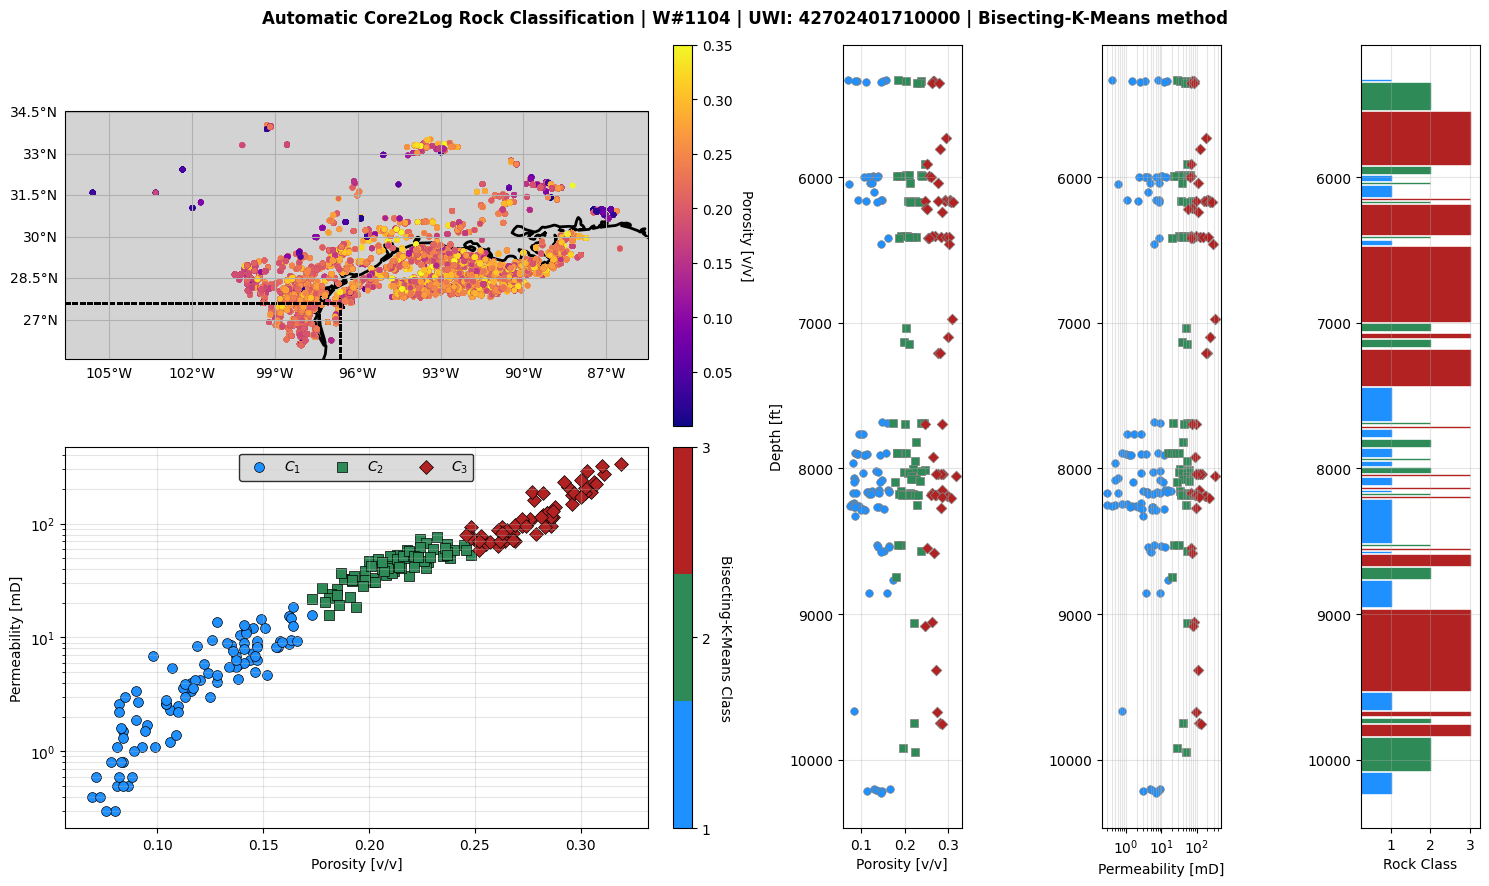

Elapsed time: 6.792 seconds
--------------------------------------------------------------------------------


In [3]:
# RUN DASHBOARD
# this module will load the Core2Log Rock Classification dashboard:
# (1) specify the well to analyze
# (2) specify the rock classification technique to use
#   (2a) if the technique is physics-based: specify cutoffs
#   (2b) if the technique is ML-based: specify the number of classes
# (3) run the dashboard to visualize results
RockClassification(well_number=1104, method='bisectkmeans', n_classes=3).run_dashboard()

--------------------------------------------------------------------------------
                       Compare Rock Classification Methods
--------------------------------------------------------------------------------
Number of Classes: 3
Leverett Cutoffs: [10, 20, 40]
Winland Cutoffs: [150, 300, 500]
Lorenz Cutoffs: [0.5, 2, 5]
--------------------------------------------------------------------------------
All data shape: (102797, 88)
Total number of wells: 1379
--------------------------------------------------------------------------------
Well #1104 | UWI: 42702401710000 | LAT: 29.29 | LONG: -88.64
Well shape: (223, 4)
--------------------------------------------------------------------------------


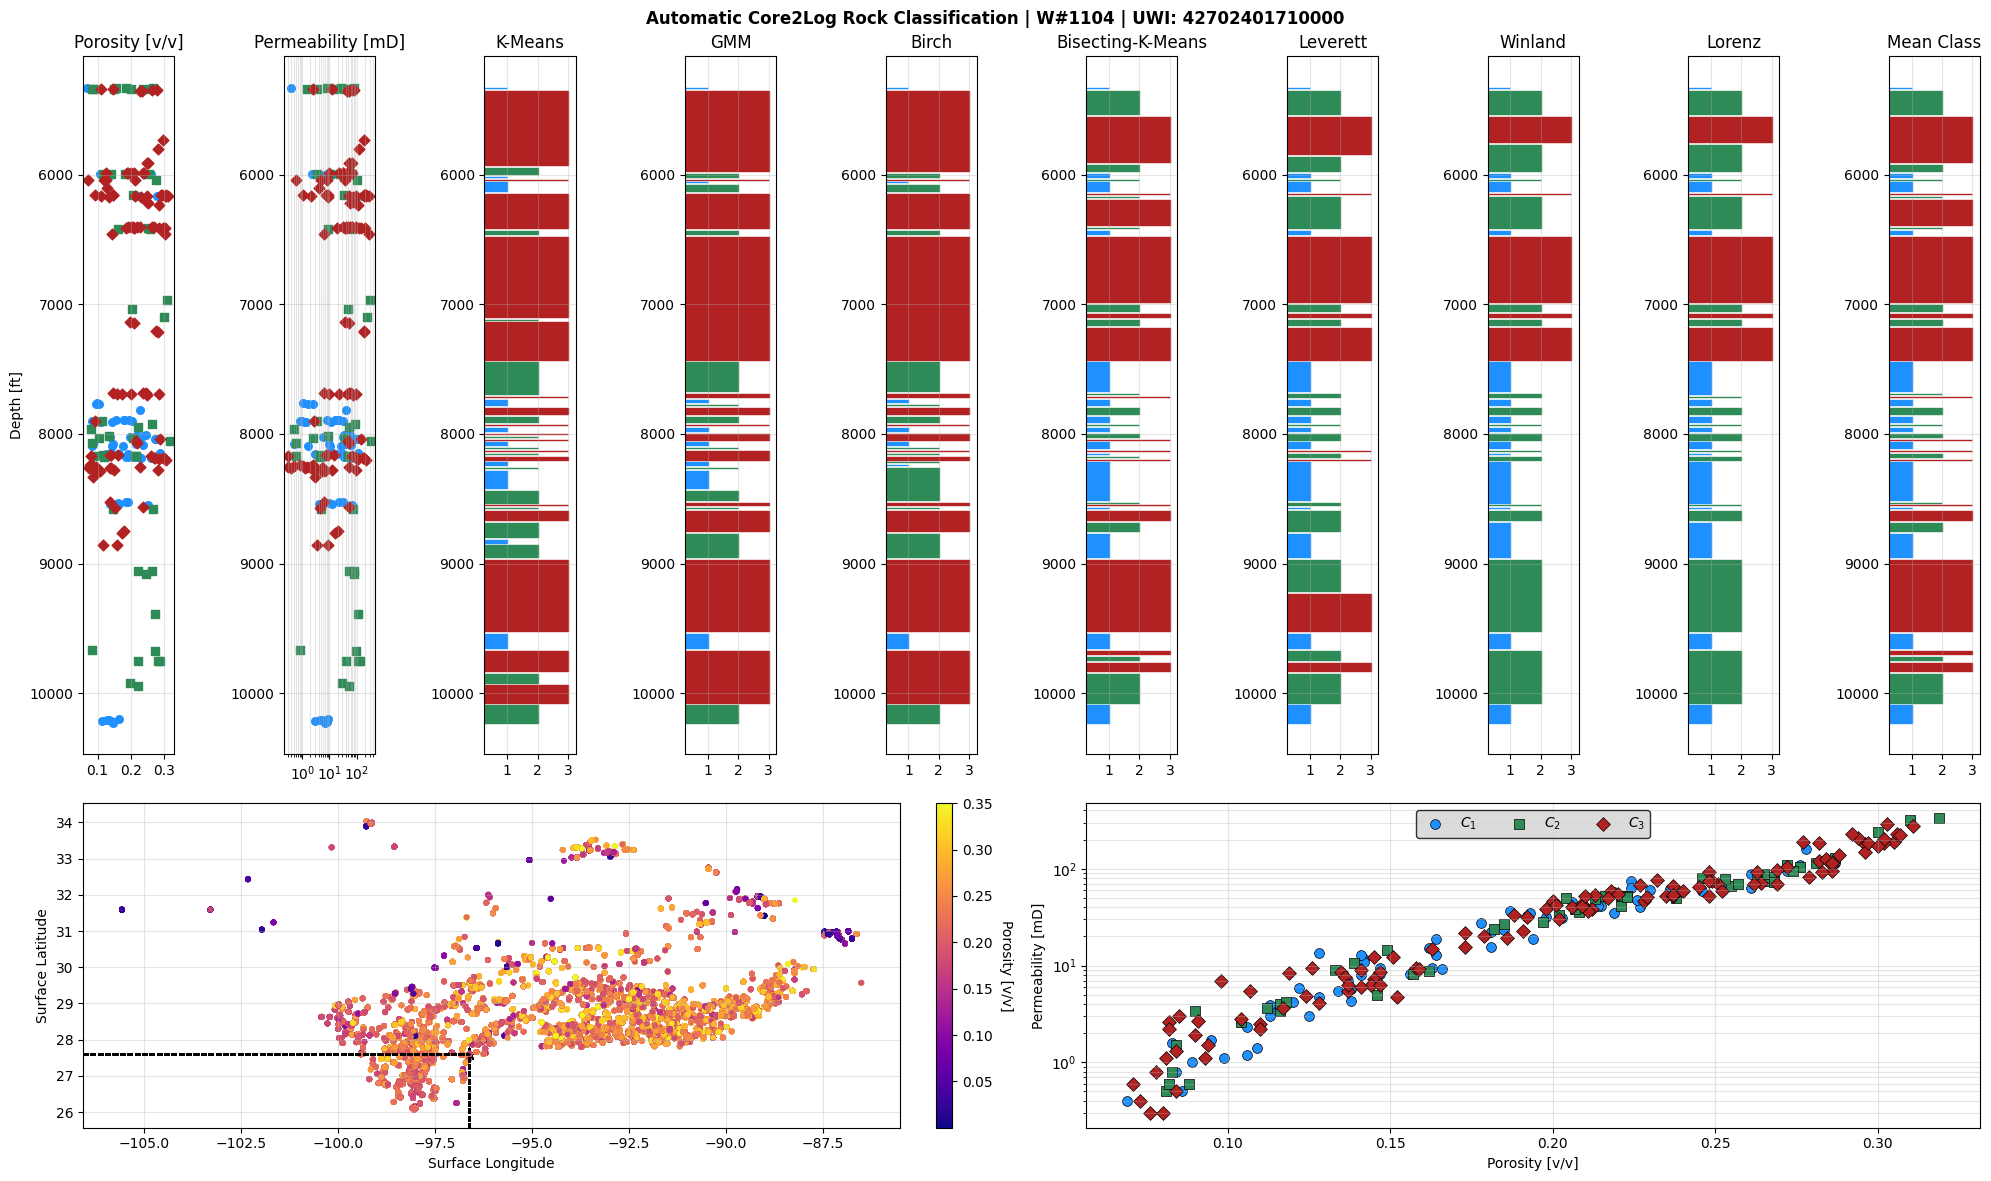

In [4]:
# COMPARISON
# compare all techniques for a given well (user must define cutoffs and n_classes accordingly)
RockClassification(well_number=1104).run_comparison(n_classes=3,
                                                    leverett_cutoffs=[10,20,40], 
                                                    winland_cutoffs=[150,300,500], 
                                                    lorenz_cutoffs=[0.5,2,5])

***
# END